# Time comparison for synology vs Nemo


In [2]:
import napari
from macrohet import dataio, tile, visualise
import os, glob
from tqdm.auto import tqdm
import pandas as pd

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [35]:
os.getpid()

871304

In [ ]:
%%time
expt_ID = 'ND0001'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'
base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/*/Images/Index*xml'))[0]

# metadata_fn = '/mnt/SYNO/macrohet_syno/ND0001/acquisition/ND0001__2023-10-27T14_12_54-Measurement 1/Images/Index.idx.xml'#glob.glob(os.path.join(base_dir, 'Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
# temporary hack to fix URL from incorrectly exported metadata
# metadata['URL'] = metadata.apply(dataio.generate_url, axis=1)
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

In [3]:
float(metadata['MeasurementTimeOffset'].unique()[1])/60

14.847333333333331

In [4]:
metadata['ChannelID'].unique()

array(['1', '2', '3'], dtype=object)

In [5]:
metadata['PlaneID'].unique()

array(['1', '2', '3'], dtype=object)

# ND0000

In [25]:
missing_fns = []
for fn in tqdm(metadata['URL']):
    if not os.path.exists(os.path.join(base_dir, f'Images/{fn}')):
        missing_fns.append(fn)

  0%|          | 0/243648 [00:00<?, ?it/s]

In [27]:
len(missing_fns)

85041

In [13]:
85041/158607

0.536174317653067

In [49]:
len(metadata)- len(missing_fns)

158607

# ND0001

In [16]:
metadata_fn

'/mnt/SYNO/macrohet_syno/ND0001/acquisition/ND0001__2023-10-27T14_12_54-Measurement 1/Images/Index.idx.xml'

In [17]:
base_dir

'/mnt/SYNO/macrohet_syno/ND0001/'

In [18]:
missing_fns = []
for fn in tqdm(metadata['URL']):
    if not os.path.exists(os.path.join(base_dir, f'acquisition/ND0001__2023-10-27T14_12_54-Measurement 1/Images/{fn}')):
        missing_fns.append(fn)

  0%|          | 0/1020600 [00:00<?, ?it/s]

In [19]:
len(missing_fns)

45441

In [22]:
import re

In [33]:
# Regular expression pattern to extract rows and columns
pattern = r'r(\d+)c(\d+)f(\d+)p(\d+)-ch(\d+)sk(\d+)fk(\d+)fl(\d+)'

# Extract rows and columns from filenames and store them in a set to ensure uniqueness
unique_values = set()
data = []
for filename in missing_fns:
    match = re.search(pattern, filename)
    if match:
        row = match.group(1)
        column = match.group(2)
        plane = match.group(4)
        time = match.group(6)
        channel = match.group(5)
        data.append((row, column, plane, time, channel))

# Create a set of unique rows and columns
unique_rows = set()
unique_columns = set()

for row, column, plane, time, channel in data:
    unique_rows.add(row)
    unique_columns.add(column)

# Check for missing planes, times, or channels in rows and columns
missing_planes = set()
missing_times = set()
missing_channels = set()

for row, column, plane, time, channel in data:
    if plane not in missing_planes:
        missing_planes.add(plane)
    if time not in missing_times:
        missing_times.add(time)
    if channel not in missing_channels:
        missing_channels.add(channel)

# Print the unique rows and columns without missing planes, times, or channels
print("Unique Rows:")
for row in unique_rows:
    if all(plane in missing_planes for plane in unique_rows):
        print(row)

print("Unique Columns:")
for column in unique_columns:
    if all(channel in missing_channels for channel in unique_columns):
        print(column)

Unique Rows:
Unique Columns:


In [29]:
len(unique_values)

42

In [30]:
unique_values

{('03', '01'),
 ('03', '02'),
 ('03', '03'),
 ('03', '04'),
 ('03', '05'),
 ('03', '06'),
 ('03', '07'),
 ('03', '08'),
 ('03', '09'),
 ('03', '10'),
 ('03', '11'),
 ('03', '12'),
 ('04', '03'),
 ('04', '04'),
 ('04', '05'),
 ('04', '06'),
 ('04', '07'),
 ('04', '08'),
 ('04', '09'),
 ('04', '10'),
 ('04', '11'),
 ('04', '12'),
 ('05', '03'),
 ('05', '04'),
 ('05', '05'),
 ('05', '06'),
 ('05', '07'),
 ('05', '08'),
 ('05', '09'),
 ('05', '10'),
 ('05', '11'),
 ('05', '12'),
 ('06', '03'),
 ('06', '04'),
 ('06', '05'),
 ('06', '06'),
 ('06', '07'),
 ('06', '08'),
 ('06', '09'),
 ('06', '10'),
 ('06', '11'),
 ('06', '12')}

### which positions are missing

In [ ]:
len(metadata)- len(missing_fns)

In [ ]:
len(missing_fns)/len(metadata)*100

# Testing time to read all fns

In [73]:
75*2*3*9

4050

In [ ]:
r03c01f01p01-ch1sk1fk1fl1

In [106]:
%%timeit
fns = glob.glob('/mnt/DATA/macrohet/PS0000/acquisition/Images/*r03c04*ch*')

164 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
len(fns)

4050

In [108]:
%%timeit
fns = glob.glob('/mnt/NEMO/home/users/dayn/macrohet_nemo/PS0000/acquisition/Images/*.tif*')

488 ms ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
len(fns)

4050

In [110]:
%%timeit
fns = glob.glob('/mnt/SYNO/macrohet_syno/PS0000/acquisition/Images/*.tif*')

9.67 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
print(len(fns))

4050


In [33]:
449/10.1 # syno times quicker than nemo ???

44.45544554455446

In [112]:
164/9.67 # syno times quicker than my local harddrive!?

16.959669079627716

In [113]:
488/164 # local times quicker than nemo!?

2.975609756097561

### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [120]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*AssayLayout.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

### Define row and column of choice

In [122]:
acq_ID = row, column = (3, 4)

### Define subset if non-square tiling or more than one contiguous region of images in imaging well. 

In [5]:
# subset_field_IDs = ['1','6','7','8','11','12','13','14','15']

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [123]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'acquisition/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             # subset_field_IDs=['16', '17',  '20', '21'], 
                             # n_tile_rows = 2, n_tile_cols = 2,
                             set_plane='max_proj',
                             # set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()
images

CPU times: user 1.66 s, sys: 0 ns, total: 1.66 s
Wall time: 2.53 s


dask.array<max-aggregate, shape=(150, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2160, 2160), chunktype=numpy.ndarray>

In [101]:
%%time 
### this is NEMO
images = images.compute().compute()

CPU times: user 6h 36min 7s, sys: 49min 7s, total: 7h 25min 14s
Wall time: 53min 52s


In [125]:
%%time 
### this is SYNO
images = images.compute().compute()

CPU times: user 6h 29min 13s, sys: 48min 21s, total: 7h 17min 35s
Wall time: 29min 14s


In [154]:
images.shape

(150, 2, 6048, 6048)

In [127]:
viewer = napari.Viewer(title = f'testing speed of image load fgrom syno {expt_ID}')

viewer.add_image(images, channel_axis = 1)

[<Image layer 'Image' at 0x7f59a772ea60>,
 <Image layer 'Image [1]' at 0x7f599434e040>]

In [137]:
import btrack
scale_factor = 1/5.04

In [135]:
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/testing_{row, column}.h5'), 
                                   'r', 
                                   obj_type='obj_type_1'
                                   ) as reader:
#             writer.write_objects(objects)
        tracks = reader.tracks
        segmentation = reader.segmentation

[INFO][2024/01/16 04:38:30 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/16 04:38:30 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/16 04:38:30 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/16 04:38:31 pm] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/16 04:39:26 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/01/16 04:39:26 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5


In [138]:
recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks ,scale = (1/scale_factor,1/scale_factor))

In [139]:
filtered_tracks = [t for t in tracks if len(t)>15]

In [140]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)

In [148]:
viewer.add_tracks(napari_tracks, scale = (20, 1/scale_factor,1/scale_factor,))

<Tracks layer 'napari_tracks [2]' at 0x7f59308f8f10>

In [143]:
viewer.add_labels(recolored_segmentation)

<Labels layer 'recolored_segmentation' at 0x7f59302664c0>

In [150]:
.shape

(2, 6048, 6048)

In [153]:
viewer.add_image(images[14], channel_axis=0)

[<Image layer 'Image [2]' at 0x7f5930e65f10>,
 <Image layer 'Image [3]' at 0x7f59308a8790>]

In [142]:
print()

In [155]:
base_dir

'/mnt/SYNO/macrohet_syno/ND0002/'

In [156]:
for fn in glob.glob(os.path.join(base_dir, 'labels/testing*')):
    
    with btrack.io.HDF5FileHandler(fn, 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
    #             writer.write_objects(objects)
            tracks = reader.tracks
            # segmentation = reader.segmentation
    filtered_tracks = [t for t in tracks if len(t)>15]
    napari_tracks, _, _ = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)
    viewer.add_tracks(napari_tracks, scale = (1/scale_factor,1/scale_factor,), name = os.path.basename(fn))

[INFO][2024/01/17 09:36:12 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/17 09:36:12 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/17 09:36:12 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/17 09:36:13 am] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/17 09:36:15 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
[INFO][2024/01/17 09:36:15 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testi

### Coarse measure of cell tracking performance

In [157]:
import matplotlib.pyplot as plt

[INFO][2024/01/17 10:00:41 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/17 10:00:41 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/17 10:00:41 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/17 10:00:42 am] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/17 10:00:43 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
[INFO][2024/01/17 10:00:43 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testi

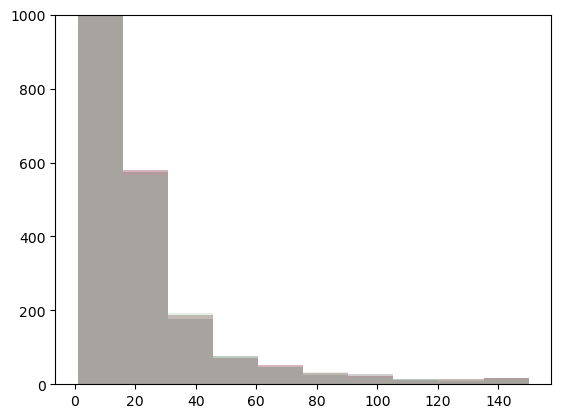

In [161]:
# Optional: Define a list of colors if you want specific colors
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
color_idx = 0

for fn in glob.glob(os.path.join(base_dir, 'labels/testing*')):
    with btrack.io.HDF5FileHandler(fn, 'r', obj_type='obj_type_1') as reader:
        tracks = reader.tracks

    # Plotting with varying colors and transparency
    plt.hist([len(track) for track in tracks], color=colors[color_idx % len(colors)], alpha=0.1)

    # Increment color index for next iteration
    color_idx += 1

# Set y-axis limit
plt.ylim(0, 1000)

# Display the plot
plt.show()

# Trying two channel segmentation

In [43]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# model = models.Cellpose(gpu=True, model_type='cyto')
model_path = '/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/models/models/macrohet_seg'
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)
def segment(img, diameter = 30, channels = [0,0]):
    masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels,
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Jan  4 15:27:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:65:00.0  On |                  Off |
| 30%   47C    P8              35W / 300W |   3352MiB / 49140MiB |      0%      D

INFO:cellpose.core:** TORCH CUDA version installed and working. **


>>> GPU activated? YES


INFO:cellpose.models:>> cyto << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


In [36]:
img = images[0]

In [37]:
img.shape

(2, 6048, 6048)

In [44]:
masks = segment(img, diameter = None)

ValueError: not enough values to unpack (expected 4, got 3)

In [57]:
model = models.Cellpose(gpu=True, model_type='cyto')
output = model.eval(img, diameter = 300)#, diameter=diameter, channels=channels,
                                             # flow_threshold=None, cellprob_threshold=0)

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>> cyto << model set to be used
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 112.45 sec


In [58]:
output[0].shape
masks = output[0]

In [59]:
viewer.add_labels(masks)

<Labels layer 'masks [3]' at 0x7effa00f3d90>

In [48]:
print()

In [72]:
img

dask.array<getitem, shape=(2, 6048, 6048), dtype=uint16, chunksize=(2, 2160, 2160), chunktype=numpy.ndarray>

# Trying a new segmentation approach

In [69]:
import torch
print(torch.__version__)

2.1.1+cu121


In [71]:
from segment_anything import SamPredictor, sam_model_registry


ModuleNotFoundError: No module named 'torchvision.ops'

In [77]:
import numpy as np

In [78]:
np.save('t0_ND2.npy', cut_images[0])